In [ ]:
import os
import openai
import anthropic
import together
import subprocess
import re

# open ai API key
openai_api_key=''
# anthropic API key
claude_api_key = ''

# together AI API key
together_api_key = ''

In [2]:
# read the prompt from the prompt text file titled "cntnv.txt"
with open("../prompts/cntnv.txt", "r") as f:
    prompt = f.read()

prompt = str(prompt)

In [3]:
claude_client = anthropic.Anthropic(api_key = claude_api_key)
openai_client = openai.OpenAI(api_key = openai_api_key)
togetherai_client = together.Together(api_key=together_api_key)

## GPT 4o

In [7]:
completion = openai_client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [8]:
print(response)

### Solution Explanation

In this problem, we're tasked with determining the optimal quantity of a product the vendor should order to maximize their expected profit, given that the demand follows a Burr Type XII distribution.

### 1. Analytical / Closed-Form Approach

To solve this analytically, we start by defining the profit function:

Given:
- \( x \): order quantity
- \( D \): demand, a random variable following a Burr Type XII distribution with parameters \(\alpha\) and \(\beta\)
- Profit, \( \Pi(x) \), for a given \(x\) is defined as:

\[ 
\Pi(x) = 
\begin{cases} 
sD - cx + w(x - D), & \text{if } D \leq x \\
sx - cx, & \text{if } D > x 
\end{cases}
\]

Expected profit is:

\[
E[\Pi(x)] = \int_0^x \left( sD - cx + w(x - D) \right) f(D) \,dD + \int_x^\infty \left( sx - cx \right) f(D) \,dD 
\]

Where \(f(D)\) is the probability density function of the Burr distribution. Simplifying, we have:

\[
E[\Pi(x)] = \int_0^x \left((s-w)D + wx - cx \right) f(D) \,dD + \int_x^\infty (s-c)x f(

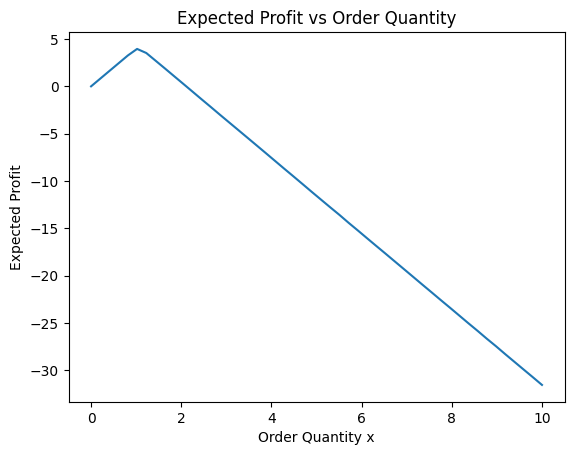

Recommended Order Quantity: 1.0204081632653061
Expected Profit: 3.96


In [10]:
import numpy as np
from scipy.stats import burr
import matplotlib.pyplot as plt

def simulate_profit(x, c=5, s=9, w=1, alpha=2, beta=20, num_simulations=10000):
    # Generate random demand from the Burr Type XII distribution
    demand_dist = burr(c=beta, d=alpha)
    demands = demand_dist.rvs(size=num_simulations)
    
    # Calculate profit for each simulation run
    profits = np.where(
        demands <= x,
        (s-w) * demands + (w-c) * x,  # Case where demand <= x
        (s-c) * x                     # Case where demand > x
    )
    
    # Compute the average profit
    expected_profit = np.mean(profits)
    profit_std_error = np.std(profits) / np.sqrt(num_simulations)
    
    return expected_profit, profit_std_error

def optimize_order_quantity(num_trials=50, num_simulations=10000):
    # Explore different order quantities
    candidate_xs = np.linspace(0, 10, num_trials)
    best_x = 0
    best_profit = float('-inf')
    all_profits = []
    
    for x in candidate_xs:
        exp_profit, _ = simulate_profit(x, num_simulations=num_simulations)
        all_profits.append(exp_profit)
        if exp_profit > best_profit:
            best_profit = exp_profit
            best_x = x
            
    return best_x, best_profit, all_profits

best_x, best_profit, all_profits = optimize_order_quantity()

# Plotting results
plt.plot(np.linspace(0, 10, 50), all_profits)
plt.xlabel('Order Quantity x')
plt.ylabel('Expected Profit')
plt.title('Expected Profit vs Order Quantity')
plt.show()

print(f"Recommended Order Quantity: {best_x}")
print(f"Expected Profit: {best_profit:.2f}")

## o1

In [11]:
completion = openai_client.chat.completions.create(
    model="o1",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [12]:
print(response)

Solution Explanation

We have a classical single‐period (newsvendor‐type) inventory problem with salvage.  The objective is to choose an ordering quantity x ≥ 0 each morning so as to maximize the expected daily profit.  

Key Elements of the Model
-------------------------
• Per‐unit cost: c  
• Per‐unit selling price: s  
• Per‐unit salvage value: w  
• Daily demand D ∼ Burr(α, β) with cumulative distribution:
  F(d) = 1 − [1 + d^α]^(−β),  d > 0.  

Because of salvage, each unit that remains unsold at the end of the day is recovered at w.  Hence, the “overstock” cost is (c − w) if a unit is purchased but not sold, while the “understock” or “lost‐sale” cost is (s − c) if a unit could have been sold but was not in inventory.

-------------------------------------------------------------------------------
1. Closed‐Form (Analytical) Approach
-------------------------------------------------------------------------------
Under fairly standard newsvendor reasoning, the optimal solution x* 

In [16]:
import math
import random

def burr_type_xii(alpha, beta):
    """
    Generate one sample from Burr(α, β) distribution.
    Inverse-CDF method:
      U ~ Uniform(0,1)
      D = ( (1 - U)^(-1/beta) - 1 )^(1/alpha)
    """
    U = random.random()
    return (( (1 - U)**(-1.0 / beta) - 1.0 )**(1.0 / alpha))

def simulate_profit(x, alpha, beta, c, s, w, n_reps=1000):
    """
    Estimate the expected profit by Monte Carlo.
    x: ordering quantity
    alpha, beta: Burr distribution parameters
    c, s, w: cost, price, salvage
    n_reps: number of Monte Carlo trials
    """
    profits = []
    for _ in range(n_reps):
        d = burr_type_xii(alpha, beta)
        # Sold units:
        sold = min(d, x)
        # Unsold units: 
        unsold = max(0.0, x - d)

        revenue = s * sold
        cost = c * x
        salvage = w * unsold
        profit = revenue + salvage - cost
        profits.append(profit)
    return sum(profits)/len(profits), (sum((p - sum(profits)/len(profits))**2 for p in profits) / (len(profits)-1))

def random_search(alpha, beta, c, s, w, budget=1000, mc_reps=1000):
    """
    Random search over x >= 0 (sample x from some proposal distribution).
    Returns best x found within the budget and its estimated profit.
    """
    best_x = 0.0
    best_profit = -1e9
    # Simple proposal: Exponential(mean=1), truncated to avoid extremely large values
    for _ in range(budget):
        x_candidate = random.expovariate(1.0)
        # Limit x to keep search in a reasonable range (optional):
        if x_candidate > 5.0:
            x_candidate = 5.0 + random.random()  # ensure variety but avoid extremes
        mean_profit, var_est = simulate_profit(x_candidate, alpha, beta, c, s, w, n_reps=mc_reps)
        if mean_profit > best_profit:
            best_profit = mean_profit
            best_x = x_candidate
    return best_x, best_profit

def main():
    # Default parameters
    c = 5.0
    s = 9.0
    w = 1.0
    alpha = 2.0
    beta = 20.0

    # Baseline with x=0 just to show any improvement
    baseline_profit, baseline_var = simulate_profit(0.0, alpha, beta, c, s, w, 2000)
    print(f"Baseline x=0 => Profit ~ {baseline_profit:.4f}  (Variance ~ {baseline_var:.4f})")

    # Example of simulating around a "small guess", e.g. x=0.5
    guess_profit, guess_var = simulate_profit(0.5, alpha, beta, c, s, w, 2000)
    print(f"Trial x=0.5 => Profit ~ {guess_profit:.4f}  (Variance ~ {guess_var:.4f})")

    # Random search with a budget of 1000 (can adjust as needed)
    budget = 1000
    best_x, best_profit = random_search(alpha, beta, c, s, w, budget=budget, mc_reps=500)
    print(f"Random search best x => {best_x:.4f},  Profit ~ {best_profit:.4f}")

if __name__ == "__main__":
    main()

    # run the above code 1000 times to get mean and std for the best_x and best_profit
    num_runs = 1000
    all_best_x = []
    all_best_profit = []
    budget = 1000
    for _ in range(num_runs):
        best_x, best_profit = random_search(alpha, beta, c, s, w, budget=budget, mc_reps=500)
        all_best_x.append(best_x)
        all_best_profit.append(best_profit)
    mean_best_x = sum(all_best_x) / num_runs
    mean_best_profit = sum(all_best_profit) / num_runs
    std_best_x = (sum((x - mean_best_x) ** 2 for x in all_best_x) / (num_runs - 1)) ** 0.5
    std_best_profit = (sum((p - mean_best_profit) ** 2 for p in all_best_profit) / (num_runs - 1)) ** 0.5
    print(f"Mean Best x: {mean_best_x:.4f}, Std Dev: {std_best_x:.4f}")
    print(f"Mean Best Profit: {mean_best_profit:.4f}, Std Dev: {std_best_profit:.4f}")


Baseline x=0 => Profit ~ 0.0000  (Variance ~ 0.0000)
Trial x=0.5 => Profit ~ -0.3790  (Variance ~ 0.7293)
Random search best x => 0.1950,  Profit ~ 0.4892
Mean Best x: 0.1984, Std Dev: 0.0155
Mean Best Profit: 0.5009, Std Dev: 0.0085


## o3-mini

In [17]:
completion = openai_client.chat.completions.create(
    model="o3-mini",
    messages=[
        {"role": "system", "content": "You are an expert in probability theory and stochastic modeling."},
        {"role": "user", "content": prompt},
    ]
)

# get the response
response = completion.choices[0].message.content

In [18]:
print(response)

Below is one complete solution that first shows a closed‐form derivation and then a simulation model to verify and “discover” the optimal order quantity.

───────────────────────────── 
1. Analytical / Closed‐Form Approach

Recall the vendor’s profit is given by

  Profit(x,D) = s·min{D,x} + w·(x – min{D,x}) – c·x.

With the given parameters (c = 5, s = 9, w = 1) the expression can be rearranged as

  Profit(x,D) = (s – w)·min{D,x} – (c – w)·x
          = 8·min{D,x} – 4·x.

Thus, the expected profit is

  π(x) = 8·E[min{D,x}] – 4·x.

A standard result in inventory theory is that

  E[min{D,x}] = ∫₀ˣ P(D > t) dt.

For the Burr Type XII distribution with CDF
  F(t) = 1 – [1 + t^α]^(–β)
(with α = 2 and β = 20),
we have
  P(D > t) = 1 – F(t) = [1 + t²]^(–20).

Thus,
  E[min{D,x}] = ∫₀ˣ [1 + t²]^(–20) dt
and the expected profit is
  π(x) = 8·∫₀ˣ [1 + t²]^(–20) dt – 4x.

To maximize π(x), differentiate with respect to x. By the Leibniz rule,
  d/dx E[min{D,x}] = [1 + x²]^(–20),
so that:
  π′

In [21]:
import math
import random
import statistics

# Given parameters
c = 5      # per-unit cost
s = 9      # per-unit selling price
w = 1      # salvage value
alpha = 2  # Burr parameter
beta = 20  # Burr parameter

# Derived constants for profit: profit = (s-w)min{D,x} - (c-w)x = 8 min{D,x} - 4x
mult = s - w   # 8
fixed_cost = c - w  # 4

# Inverse CDF (quantile function) for the Burr Type XII distribution:
def burr_inverse(u, alpha, beta):
    # Given u = 1 - [1 + x^alpha]^{-beta}
    # => [1 + x^alpha] = (1/(1-u))^(1/beta)
    # => x = ( (1/(1-u))^(1/beta) - 1 )^(1/alpha)
    return ((1/(1 - u))**(1/beta) - 1)**(1/alpha)

# Simulation of daily demand using inverse transform
def simulate_demand(alpha, beta):
    u = random.random()
    return burr_inverse(u, alpha, beta)

# Compute profit for a given x and a realized demand d
def profit_for_sample(x, d):
    sold = min(d, x)
    return mult * sold - fixed_cost * x

# For a given ordering quantity x, simulate many replications to estimate expected profit.
def estimate_expected_profit(x, n_replications=100000):
    profits = []
    for _ in range(n_replications):
        d = simulate_demand(alpha, beta)
        profits.append(profit_for_sample(x, d))
    avg = statistics.mean(profits)
    stdev = statistics.pstdev(profits)
    # 95% CI using Normal approximation:
    ci_half_width = 1.96 * stdev / math.sqrt(n_replications)
    return avg, ci_half_width

# Use a grid-based search within a reasonable range for x (say, 0 to 0.5) to locate the optimum.
# We'll use our total evaluation budget to decide number of grid points.
BUDGET = 1000  # total number of objective function evaluations allowed (replications count from grid points)
# For instance, if we evaluate 20 candidate values, we can use 1000/20 = 50 replications per candidate.
n_candidates = 20
n_replications = max(1, BUDGET // n_candidates)

grid = [i * 0.5 / (n_candidates - 1) for i in range(n_candidates)]
results = []

print("Grid search over x with {} replications per candidate:".format(n_replications))
for x in grid:
    exp_profit, ci = estimate_expected_profit(x, n_replications)
    results.append((x, exp_profit, ci))
    print("x = {:.4f}, Estimated Exp Profit = {:.4f}, 95% CI ± {:.4f}".format(x, exp_profit, ci))

# Identify candidate with maximum profit:
best = max(results, key=lambda tup: tup[1])
print("\nRecommended ordering quantity from grid search: x = {:.4f}".format(best[0]))
print("Estimated expected profit = {:.4f} with 95% CI ± {:.4f}".format(best[1], best[2]))

# Verify improvement over baseline x = 0:
baseline_profit, baseline_ci = estimate_expected_profit(0, n_replications)
print("\nBaseline (x=0): Estimated expected profit = {:.4f} with 95% CI ± {:.4f}".format(baseline_profit, baseline_ci))

# For confirmation, we can print the closed-form optimum:
x_opt_closed = math.sqrt(2**(1/beta) - 1)  # note beta=20
print("\nClosed-form candidate: x* = √(2^(1/20) - 1) = {:.4f}".format(x_opt_closed))

Grid search over x with 50 replications per candidate:
x = 0.0000, Estimated Exp Profit = 0.0000, 95% CI ± 0.0000
x = 0.0263, Estimated Exp Profit = 0.1053, 95% CI ± 0.0000
x = 0.0526, Estimated Exp Profit = 0.1934, 95% CI ± 0.0174
x = 0.0789, Estimated Exp Profit = 0.2715, 95% CI ± 0.0349
x = 0.1053, Estimated Exp Profit = 0.3635, 95% CI ± 0.0414
x = 0.1316, Estimated Exp Profit = 0.3957, 95% CI ± 0.0597
x = 0.1579, Estimated Exp Profit = 0.5100, 95% CI ± 0.0661
x = 0.1842, Estimated Exp Profit = 0.5218, 95% CI ± 0.0897
x = 0.2105, Estimated Exp Profit = 0.4890, 95% CI ± 0.1205
x = 0.2368, Estimated Exp Profit = 0.3237, 95% CI ± 0.1518
x = 0.2632, Estimated Exp Profit = 0.3338, 95% CI ± 0.1700
x = 0.2895, Estimated Exp Profit = 0.4078, 95% CI ± 0.1849
x = 0.3158, Estimated Exp Profit = 0.3522, 95% CI ± 0.1842
x = 0.3421, Estimated Exp Profit = 0.0952, 95% CI ± 0.1842
x = 0.3684, Estimated Exp Profit = 0.1136, 95% CI ± 0.2344
x = 0.3947, Estimated Exp Profit = 0.0985, 95% CI ± 0.2319
x

## Claude Sonnet

In [22]:
response = claude_client.messages.create(
    model="claude-3-5-sonnet-20241022",  # Or another Claude 3 model
    max_tokens=4096,
    system="You are an expert in probability theory and stochastic modeling.",
    messages=[
        {"role": "user", "content": prompt}
    ]
)

print(response.content[0].text)

I'll help solve this newsvendor-type problem with a comprehensive approach.

Analysis:
---------
1. This is a classic single-period inventory problem with the following expected profit function:

E[Profit(x)] = s⋅E[min(D,x)] - cx + w⋅E[max(0, x-D)]

where x is the order quantity and D is the Burr Type XII distributed demand.

2. For optimality, we need the critical fractile solution where:
F(x*) = (s-c)/(s-w)

Given the Burr CDF, this leads to:
1 - [1 + (x*)^alpha]^(-beta) = (s-c)/(s-w)

Let's solve this using both analytical and simulation approaches:

```python
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Parameters
s = 9  # selling price
c = 5  # cost
w = 1  # salvage value
alpha = 2  # Burr parameter
beta = 20  # Burr parameter
np.random.seed(42)

def generate_burr_demand(n_samples):
    """Generate Burr Type XII distributed demand"""
    u = np.random.uniform(0, 1, n_samples)
    return (((1-u)**(-1/beta) - 1)**(1/alpha))

def compute_p

In [30]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Parameters
s = 9  # selling price
c = 5  # cost
w = 1  # salvage value
alpha = 2  # Burr parameter
beta = 20  # Burr parameter
# np.random.seed(42)

def generate_burr_demand(n_samples):
    """Generate Burr Type XII distributed demand"""
    u = np.random.uniform(0, 1, n_samples)
    return (((1-u)**(-1/beta) - 1)**(1/alpha))

def compute_profit(x, demand):
    """Compute profit for given quantity x and demand"""
    sales = np.minimum(demand, x)
    salvage = np.maximum(0, x - demand)
    return s * sales - c * x + w * salvage

def expected_profit(x, n_samples=1000):
    """Estimate expected profit via simulation"""
    if x < 0:
        return -1e6  # penalty for negative quantities
    demand = generate_burr_demand(n_samples)
    profits = compute_profit(x, demand)
    return np.mean(profits)

# Optimization
def objective(x):
    return -expected_profit(x[0])  # negative because we minimize

# Initial guess
x0 = [0.5]

# Optimization with constraints
bounds = [(0, None)]  # x ≥ 0
result = minimize(objective, x0, bounds=bounds, method='Nelder-Mead')

# Evaluate optimal solution
x_opt = result.x[0]
profit_opt = -result.fun

# Validation
n_validation = 10000
demand_validation = generate_burr_demand(n_validation)
profits_validation = compute_profit(x_opt, demand_validation)

print(f"Optimal order quantity: {x_opt:.4f}")
print(f"Expected profit: {profit_opt:.4f}")
print(f"95% CI: ({np.percentile(profits_validation, 2.5):.4f}, "
      f"{np.percentile(profits_validation, 97.5):.4f})")

# Compare with baseline x=0
baseline_profit = expected_profit(0)
print(f"Baseline (x=0) profit: {baseline_profit:.4f}")

# run the above code 1000 times to get mean and std for the best_x and best_profit
num_runs = 1000
all_best_x = []
all_best_profit = []
for _ in range(num_runs):
    result = minimize(objective, x0, bounds=bounds, method='Nelder-Mead')
    best_x = result.x[0]
    best_profit = -result.fun
    all_best_x.append(best_x)
    all_best_profit.append(best_profit)
mean_best_x = sum(all_best_x) / num_runs
mean_best_profit = sum(all_best_profit) / num_runs
std_best_x = (sum((x - mean_best_x) ** 2 for x in all_best_x) / (num_runs - 1)) ** 0.5
std_best_profit = (sum((p - mean_best_profit) ** 2 for p in all_best_profit) / (num_runs - 1)) ** 0.5
print(f"Mean Best x: {mean_best_x:.4f}, Std Dev: {std_best_x:.4f}")
print(f"Mean Best Profit: {mean_best_profit:.4f}, Std Dev: {std_best_profit:.4f}")


Optimal order quantity: 0.1875
Expected profit: 0.4908
95% CI: (-0.4781, 0.7498)
Baseline (x=0) profit: 0.0000
Mean Best x: 0.1922, Std Dev: 0.0268
Mean Best Profit: 0.4897, Std Dev: 0.0597


## DeepSeek R1

In [55]:
import numpy as np

# Parameters
c = 5
s = 9
w = 1
alpha = 2
beta = 20
budget = 1000  # Total number of simulations allowed

# Generate demand samples using inverse transform
def generate_demand(alpha, beta, size=1):
    u = np.random.uniform(size=size)
    return ((1/(1 - u))**(1/beta) - 1)**(1/alpha)

# Profit function for a single x and demand
def profit(x, d):
    sales = np.minimum(x, d)
    salvage = np.maximum(x - d, 0)
    return s * sales + w * salvage - c * x

# Explore x values in a grid
x_min = 0.0
x_max = 1.0
num_x = 100  # Number of x points to test
step = (x_max - x_min) / num_x
x_values = np.arange(x_min, x_max + step, step)
num_replications = budget // num_x  # Each x gets this many samples

# Store all profits for each x to compute variance
all_profits = []

for x in x_values:
    demands = generate_demand(alpha, beta, size=num_replications)
    profits = profit(x, demands)
    all_profits.append(profits)

avg_profits = [np.mean(profits) for profits in all_profits]
var_profits = [np.var(profits, ddof=1) for profits in all_profits]  # Sample variance

optimal_idx = np.argmax(avg_profits)
optimal_x = x_values[optimal_idx]
max_avg_profit = avg_profits[optimal_idx]
var_optimal = var_profits[optimal_idx]
std_error = np.sqrt(var_optimal / num_replications)
confidence_interval = (max_avg_profit - 1.96 * std_error, max_avg_profit + 1.96 * std_error)

# Compare with x=0
x0_profit = 0  # For x=0, profit is 0

print(f"Optimal x: {optimal_x:.4f}")
print(f"Expected profit: {max_avg_profit:.2f}")
print(f"95% CI for profit: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
print(f"Profit at x=0: {x0_profit:.2f}")

# at the optimal x, run the code 1000 times to get mean and std for the best_x and best_profit
num_runs = 1000
all_best_x = []
all_best_profit = []
for _ in range(num_runs):
    demands = generate_demand(alpha, beta, size=num_replications)
    profits = profit(optimal_x, demands)
    best_profit = np.mean(profits)
    all_best_x.append(optimal_x)
    all_best_profit.append(best_profit)

mean_best_x = sum(all_best_x) / num_runs
mean_best_profit = sum(all_best_profit) / num_runs
std_best_x = (sum((x - mean_best_x) ** 2 for x in all_best_x) / (num_runs - 1)) ** 0.5
std_best_profit = (sum((p - mean_best_profit) ** 2 for p in all_best_profit) / (num_runs - 1)) ** 0.5
print(f"Mean Best x: {mean_best_x:.4f}, Std Dev: {std_best_x:.4f}")
print(f"Mean Best Profit: {mean_best_profit:.4f}, Std Dev: {std_best_profit:.4f}")


Optimal x: 0.1800
Expected profit: 0.68
95% CI for profit: (0.64, 0.72)
Profit at x=0: 0.00
Mean Best x: 0.1800, Std Dev: 0.0000
Mean Best Profit: 0.4659, Std Dev: 0.1146
